In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools')
sys.path.append(api_path)

In [52]:
import numpy as np
import random
import sklearn

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F


from sir_ais_sampling import (run_experiments_gaussians,
                              run_experiments_2_gaussians,
                              sir_correlated_dynamics,
                              sir_independent_dynamics)

from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal)

from metrics import Evolution
from utils import DotDict, send_file_to_remote
from paths import path_to_save_remote, port_to_remote

# SIR, target = 1 gaussian

In [76]:
dim_arr = [30*(i + 1) for i in range(10)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 30000
N = 10
method_params = {'n_steps': n_steps, 'N': N}
random_seed = 42
method = 'sir_independent' 
mode_init = 'target'
print_results = True
results_independent = run_experiments_gaussians(dim_arr,  
                                                scale_proposal, 
                                                scale_target, 
                                                num_points_in_chain, 
                                                strategy_mean,
                                                device,
                                                batch_size,
                                                method_params,
                                                random_seed,
                                                mode_init,
                                                method,
                                                print_results)

------------------
mode = target
dim = 30
mean estimation of variance = 0.9973232746124268
mean estimation of mean = 0.004600784741342068
mean estimation of ess = 0.2613261326132613
------
dim = 60
mean estimation of variance = 1.0435208082199097
mean estimation of mean = 0.008222310803830624
mean estimation of ess = 0.058405840584058406
------
dim = 90
mean estimation of variance = 0.9036582112312317
mean estimation of mean = -0.037323836237192154
mean estimation of ess = 0.0087008700870087
------
dim = 120
mean estimation of variance = 3.863663611269885e-09
mean estimation of mean = -0.043878164142370224
mean estimation of ess = 0.0
------
dim = 150
mean estimation of variance = 3.916035939965923e-09
mean estimation of mean = -0.013066168874502182
mean estimation of ess = 0.0
------
dim = 180
mean estimation of variance = 3.838620088458811e-09
mean estimation of mean = -0.03700427711009979
mean estimation of ess = 0.0
------
dim = 210
mean estimation of variance = 3.790504354839186e-

Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_independent_1_gaussian.pdf to remote server....


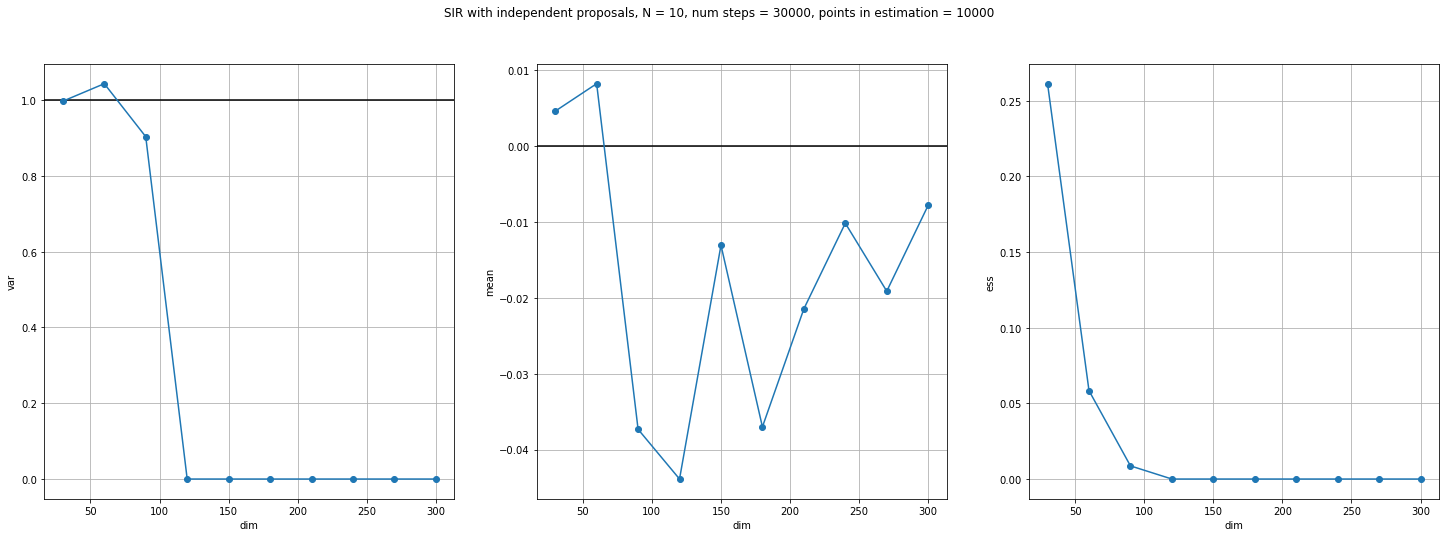

In [78]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 8))
name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(0.0, label='real', color='black')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

#axs[2].axhline(0.0, label='real', color='black')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    #axs[i].plot(dim_arr, results_independent['target'][mode], label='target init', marker='o')
    #axs[i].plot(dim_arr, results_independent['proposal'][mode], label='proposal init', marker='o')
    axs[i].plot(dim_arr, results_independent['target'][mode], marker='o')

for ax in axs:
    ax.grid()
    #ax.legend()

path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_independent_1_gaussian.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote)
plt.show()

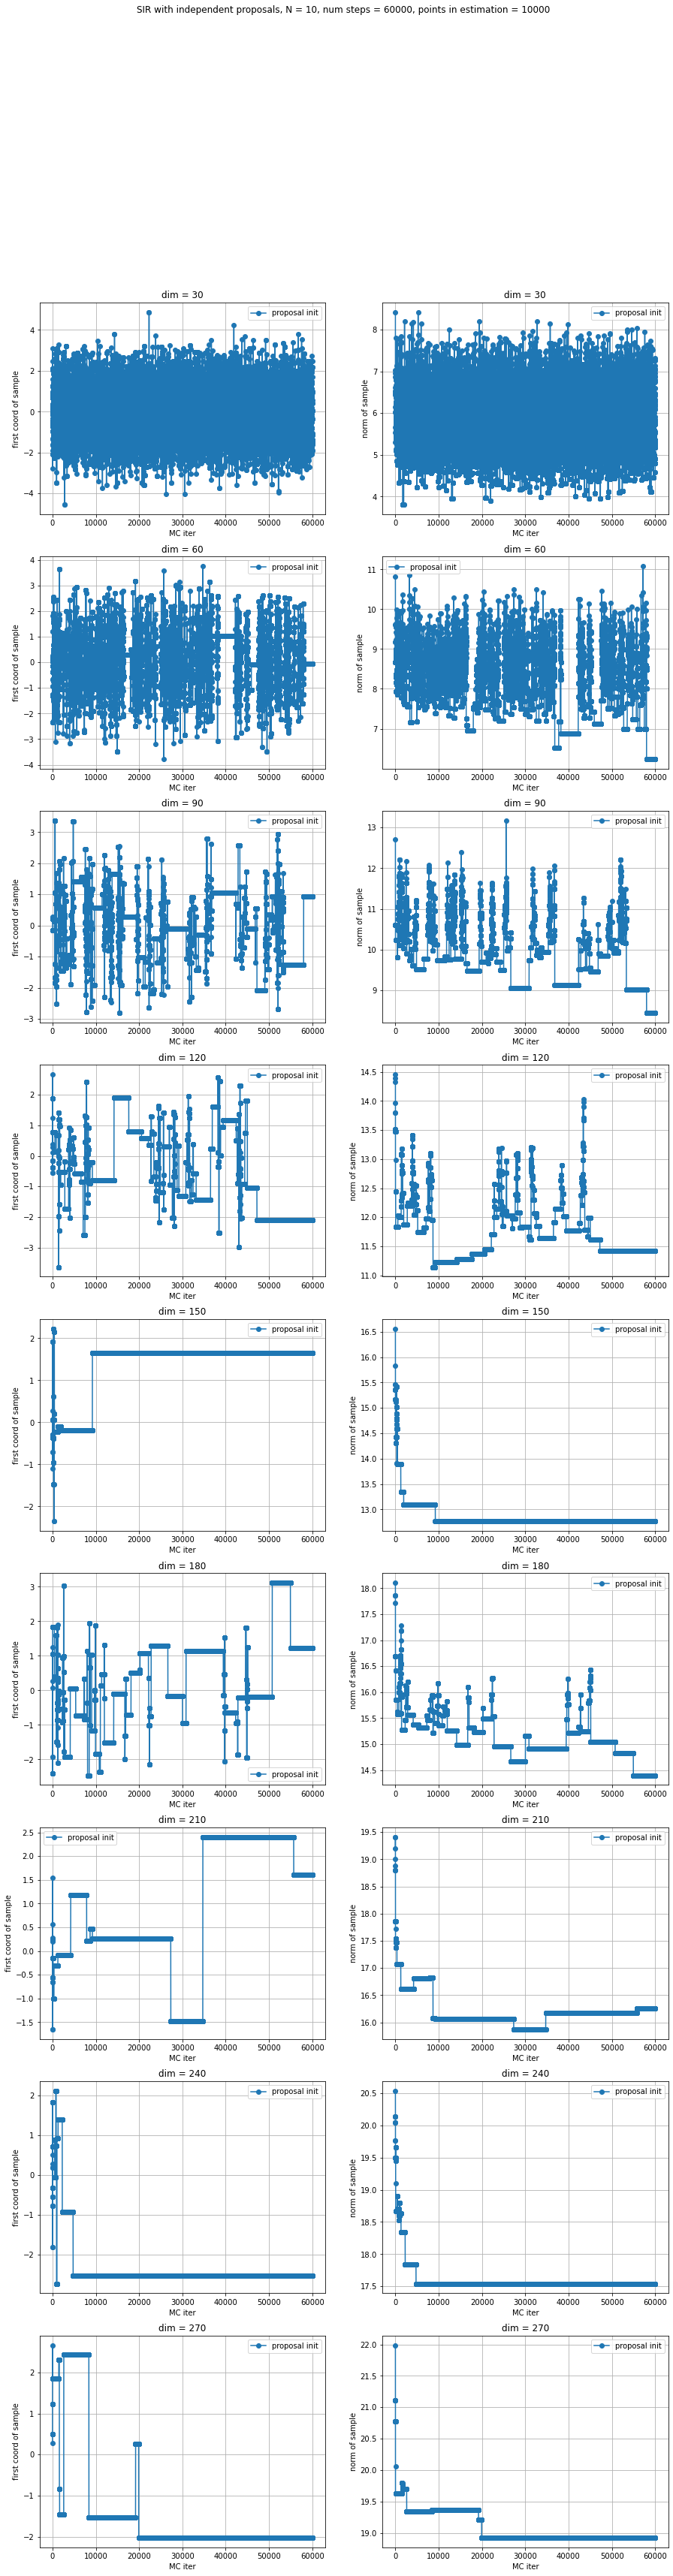

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=len(dim_arr), figsize=(15, 55))
name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

for i, dim in enumerate(dim_arr):
    axs[i][0].set_xlabel('MC iter')
    axs[i][0].set_ylabel('first coord of sample')
    #axs[i][0].plot(np.arange(len(dict_results['target']['history_first'][i])), 
    #               dict_results['target']['history_first'][i], 
    #               label=f'target init', marker='o')
    axs[i][0].plot(np.arange(len(results_independent['proposal']['history_first'][i])), 
                   results_independent['proposal']['history_first'][i], 
                   label=f'proposal init', marker='o')
    axs[i][0].set_title(f'dim = {dim}')
    axs[i][0].grid()
    axs[i][0].legend()

    axs[i][1].set_xlabel('MC iter')
    axs[i][1].set_ylabel('norm of sample')
    #axs[i][1].plot(np.arange(len(dict_results['target']['history_norm'][i])), 
    #               dict_results['target']['history_norm'][i], 
    #               label='target init', marker='o')
    axs[i][1].plot(np.arange(len(results_independent['proposal']['history_norm'][i])), 
                   results_independent['proposal']['history_norm'][i], 
                   label=f'proposal init', marker='o')
    axs[i][1].set_title(f'dim = {dim}')
    axs[i][1].grid()
    axs[i][1].legend()


plt.show()    

In [74]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 30000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_correlated' 
print_results = True
mode_init = 'proposal'
results_corr = run_experiments_gaussians(dim_arr,  
                                         scale_proposal, 
                                         scale_target, 
                                         num_points_in_chain, 
                                         strategy_mean,
                                         device,
                                         batch_size,
                                         method_params,
                                         random_seed,
                                         mode_init,
                                         method,
                                         print_results)

------------------
mode = proposal
dim = 30
mean estimation of variance = 1.0070724487304688
mean estimation of mean = -0.017963342368602753
mean estimation of ess = 0.849084908490849
------
dim = 60
mean estimation of variance = 0.9941338300704956
mean estimation of mean = -0.015106490813195705
mean estimation of ess = 0.8454845484548454
------
dim = 90
mean estimation of variance = 0.9752694964408875
mean estimation of mean = -0.030947521328926086
mean estimation of ess = 0.847084708470847
------
dim = 120
mean estimation of variance = 0.9907028079032898
mean estimation of mean = -0.012816584669053555
mean estimation of ess = 0.8453845384538454
------
dim = 150
mean estimation of variance = 0.9856138229370117
mean estimation of mean = -0.019321436062455177
mean estimation of ess = 0.8432843284328433
------
dim = 180
mean estimation of variance = 0.9703444838523865
mean estimation of mean = -0.028816070407629013
mean estimation of ess = 0.8481848184818482
------
dim = 210
mean estimat

No handles with labels found to put in legend.


Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_correlated_1_gaussian.pdf to remote server....


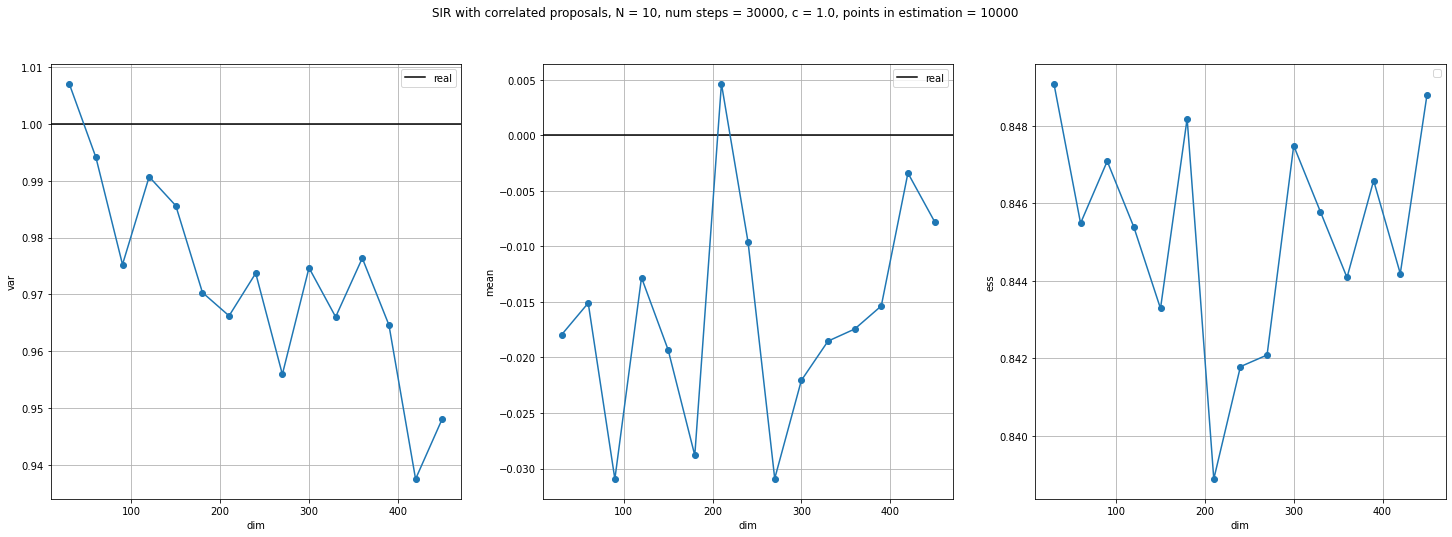

In [75]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 8))
name = f'SIR with сorrelated proposals, N = {N}, num steps = {n_steps}, c = {c}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(0.0, label='real', color='black')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    #axs[i].plot(dim_arr, results_corr['target'][mode], label='target init', marker='o')
    #axs[i].plot(dim_arr, results_corr['proposal'][mode], label='proposal init', marker='o')
    axs[i].plot(dim_arr, results_corr['proposal'][mode], marker='o')

for ax in axs:
    ax.grid()
    ax.legend()

path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_correlated_1_gaussian.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote)    

plt.show()

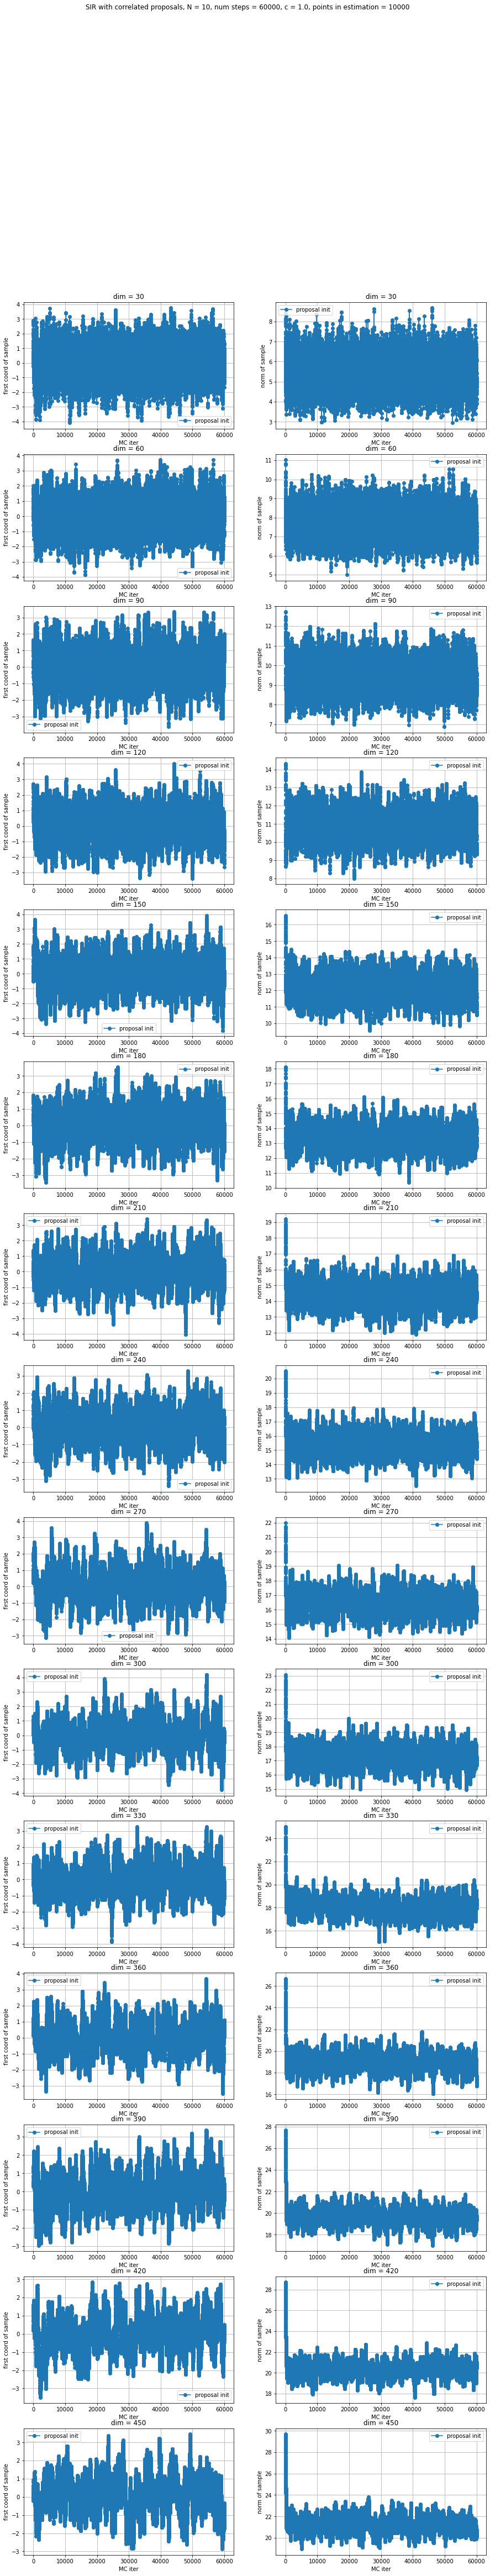

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=len(dim_arr), figsize=(15, 75))
name = f'SIR with сorrelated proposals, N = {N}, num steps = {n_steps}, c = {c}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

for i, dim in enumerate(dim_arr):
    axs[i][0].set_xlabel('MC iter')
    axs[i][0].set_ylabel('first coord of sample')
    axs[i][0].plot(np.arange(len(results_corr['proposal']['history_first'][i])), 
                   results_corr['proposal']['history_first'][i], 
                   label=f'proposal init', marker='o')
    axs[i][0].set_title(f'dim = {dim}')
    axs[i][0].grid()
    axs[i][0].legend()

    axs[i][1].set_xlabel('MC iter')
    axs[i][1].set_ylabel('norm of sample')
    axs[i][1].plot(np.arange(len(results_corr['proposal']['history_norm'][i])), 
                   results_corr['proposal']['history_norm'][i], 
                   label='proposal init', marker='o')
    axs[i][1].set_title(f'dim = {dim}')
    axs[i][1].grid()
    axs[i][1].legend()


plt.show()    

In [4]:
dim_arr = [30*(i + 1) for i in range(10)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
n_steps = 30000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_correlated' 
print_results = True
results_corr = run_experiments_gaussians(dim_arr,  
                                         scale_proposal, 
                                         scale_target, 
                                         num_points_in_chain, 
                                         strategy_mean,
                                         device,
                                         batch_size,
                                         method_params,
                                         random_seed,
                                         method,
                                         print_results)

------------------
mode = target
dim = 30
mean estimation of variance = 0.9999545812606812
mean estimation of mean = 0.0006337745580822229
mean estimation of ess = 0.8512051205120512
------
dim = 60
mean estimation of variance = 0.9934698343276978
mean estimation of mean = 0.0014841973315924406
mean estimation of ess = 0.8499649964996501
------
dim = 90
mean estimation of variance = 0.995296061038971
mean estimation of mean = -0.0018702051602303982
mean estimation of ess = 0.8497849784978498
------
dim = 120
mean estimation of variance = 0.9786173105239868
mean estimation of mean = -0.0013981913216412067
mean estimation of ess = 0.8508350835083508
------
dim = 150
mean estimation of variance = 0.9845097064971924
mean estimation of mean = 0.0014699888415634632
mean estimation of ess = 0.8501750175017502
------
dim = 180
mean estimation of variance = 0.9754686951637268
mean estimation of mean = 0.0032223621383309364
mean estimation of ess = 0.8485648564856486
------
dim = 210
mean estima

# SIR, target = 2 gaussians

In [69]:
%autoreload 2

In [70]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
loc_1_target = 1.0
loc_2_target = -1.0

num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
n_steps = 30000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_correlated' 
mode_init = 'proposal'
print_results = True
results_corr_2 = run_experiments_2_gaussians(dim_arr,  
                                             scale_proposal, 
                                             scale_target,
                                             loc_1_target,
                                             loc_2_target,
                                             num_points_in_chain, 
                                             strategy_mean,
                                             device,
                                             batch_size,
                                             method_params,
                                             random_seed,
                                             mode_init,
                                             method,
                                             print_results)

------------------
mode = proposal
dim = 30
mean estimation of target variance = 0.9649330345694039
mean estimation of 1 mode mean  = 1.001739740371704
mean estimation of 2 mode mean  = -1.0066263675689697
mean estimation of JSD  = 0.035398959368467334
mean estimation of HQR  = 0.9492499947547912
mean estimation of ESS = 0.7905590559055906
------
dim = 60
mean estimation of target variance = 0.9684273057532629
mean estimation of 1 mode mean  = 0.997853696346283
mean estimation of 2 mode mean  = -1.0056425333023071
mean estimation of JSD  = 0.03554243594408035
mean estimation of HQR  = 0.9503100037574768
mean estimation of ESS = 0.7908890889088909
------
dim = 90
mean estimation of target variance = 0.9752672240779294
mean estimation of 1 mode mean  = 0.9903038740158081
mean estimation of 2 mode mean  = -1.0032496452331543
mean estimation of JSD  = 0.03547200188040733
mean estimation of HQR  = 0.9497600018978118
mean estimation of ESS = 0.7934193419341935
------
dim = 120
mean estimatio

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_correlated_2_gaussians.pdf to remote server....


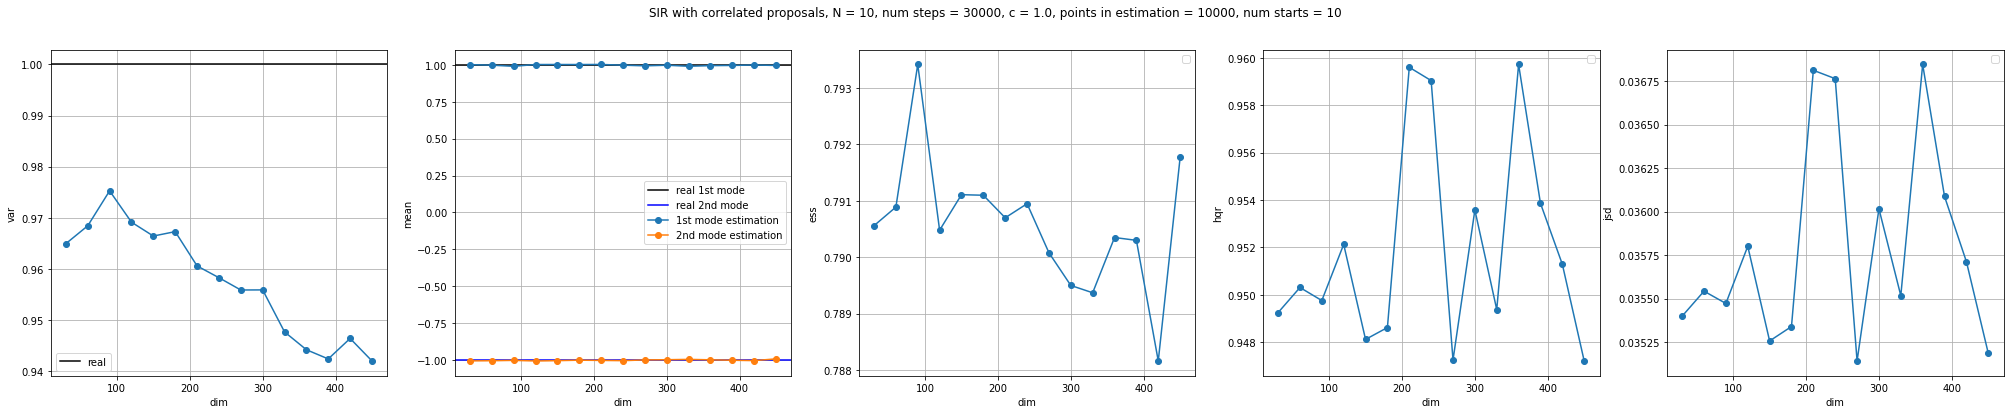

In [71]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(35, 6))
name = f'SIR with сorrelated proposals, N = {N}, num steps = {n_steps}, c = {c}, points in estimation = {num_points_in_chain}, num starts = {batch_size}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(loc_1_target, label='real 1st mode', color='black')
axs[1].axhline(loc_2_target, label='real 2nd mode', color='blue')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

axs[3].set_xlabel('dim')
axs[3].set_ylabel('hqr')

axs[4].set_xlabel('dim')
axs[4].set_ylabel('jsd')

modes_to_plot = ['mean_var', 'mean_loc_1', 'mean_loc_2', 'ess', 'mean_hqr', 'mean_jsd']
for i, mode in enumerate(modes_to_plot):
    if i == 1:
        #axs[i].plot(dim_arr, results_corr['target']['mean_loc_1'], 
        #            label='target init, 1st mode estimation', marker='o')
        axs[i].plot(dim_arr, results_corr_2['proposal']['mean_loc_1'], 
                    label='1st mode estimation', marker='o')
        #axs[i].plot(dim_arr, results_corr['target']['mean_loc_2'], 
        #            label='target init, 2nd mode estimation', marker='o')
        axs[i].plot(dim_arr, results_corr_2['proposal']['mean_loc_2'], 
                    label='2nd mode estimation', marker='o')
    elif i == 2:
        pass
    else:
        if i == 0:
            j = 0
        else:
            j = i - 1
        #axs[j].plot(dim_arr, results_corr['target'][mode], label='target init', marker='o')
        axs[j].plot(dim_arr, results_corr_2['proposal'][mode], marker='o')
    
for ax in axs:
    ax.grid()
    ax.legend()
    
path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_correlated_2_gaussians.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote) 

plt.show()

In [72]:
dim_arr = [30*(i + 1) for i in range(10)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
loc_1_target = 1.0
loc_2_target = -1.0

num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
n_steps = 30000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_independent' 
mode_init = 'target'
print_results = True
results_independent_2 = run_experiments_2_gaussians(dim_arr,  
                                                    scale_proposal, 
                                                    scale_target,
                                                    loc_1_target,
                                                    loc_2_target,
                                                    num_points_in_chain, 
                                                    strategy_mean,
                                                    device,
                                                    batch_size,
                                                    method_params,
                                                    random_seed,
                                                    mode_init,
                                                    method,
                                                    print_results)

------------------
mode = target
dim = 30
mean estimation of target variance = 0.5177300910103673
mean estimation of 1 mode mean  = 0.8630160093307495
mean estimation of 2 mode mean  = -0.8818822503089905
mean estimation of JSD  = 0.044360130093991756
mean estimation of HQR  = 0.9425499975681305
mean estimation of ESS = 0.0037703770377037703
------
dim = 60
mean estimation of target variance = 7.373292264391776e-14
mean estimation of 1 mode mean  = 0.9944514036178589
mean estimation of 2 mode mean  = -1.0214898586273193
mean estimation of JSD  = 0.04247488081455231
mean estimation of HQR  = 1.0
mean estimation of ESS = 0.0
------
dim = 90
mean estimation of target variance = 7.426876359800128e-14
mean estimation of 1 mode mean  = 1.01462721824646
mean estimation of 2 mode mean  = -0.9778567552566528
mean estimation of JSD  = 0.04247488081455231
mean estimation of HQR  = 1.0
mean estimation of ESS = 0.0
------
dim = 120
mean estimation of target variance = 7.118772735836129e-14
mean est

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_independent_2_gaussians.pdf to remote server....


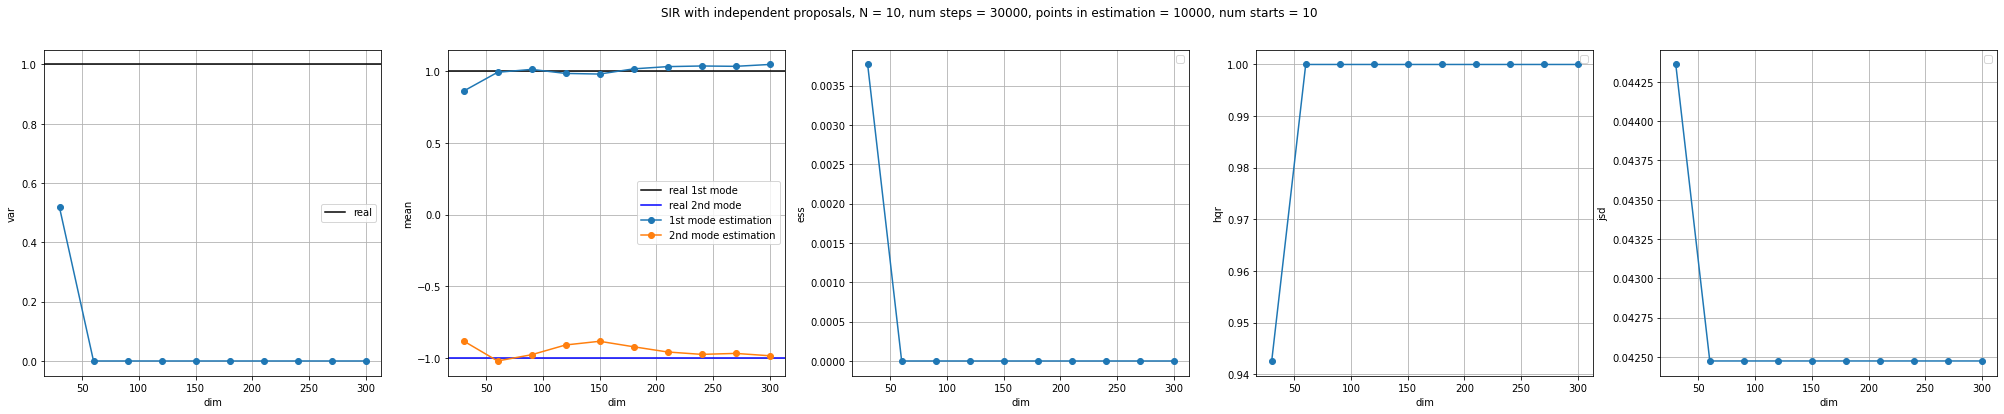

In [73]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(35, 6))
name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}, num starts = {batch_size}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(loc_1_target, label='real 1st mode', color='black')
axs[1].axhline(loc_2_target, label='real 2nd mode', color='blue')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

axs[3].set_xlabel('dim')
axs[3].set_ylabel('hqr')

axs[4].set_xlabel('dim')
axs[4].set_ylabel('jsd')

modes_to_plot = ['mean_var', 'mean_loc_1', 'mean_loc_2', 'ess', 'mean_hqr', 'mean_jsd']
for i, mode in enumerate(modes_to_plot):
    if i == 1:
        axs[i].plot(dim_arr, results_independent_2['target']['mean_loc_1'], 
                    label='1st mode estimation', marker='o')
        axs[i].plot(dim_arr, results_independent_2['target']['mean_loc_2'], 
                    label='2nd mode estimation', marker='o')
    elif i == 2:
        pass
    else:
        if i == 0:
            j = 0
        else:
            j = i - 1
        axs[j].plot(dim_arr, results_independent_2['target'][mode], marker='o')
    
for ax in axs:
    ax.grid()
    ax.legend()
    
path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_independent_2_gaussians.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote) 

plt.show()